# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Data Curation Part 2

Today we'll extend our dataset to a greater coverage, and craft it into an excellent dataset for training.  
Data curation can seem less exciting than other things we work on, but it's a crucial part of the LLM engineers' responsibility and an important craft to hone, so that you can build your own commercial solutions with high quality datasets.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## Important Note - read me first please

We are about to craft a massive dataset of 400,000 items covering multiple types of product. In Week 7 we will be using this data to train our own model. It's a pretty big dataset, and depending on the GPU you select, training could take 20+ hours. It will be really good fun, but it could cost a few dollars in compute units.

As an alternative, if you want to keep things quick & low cost, you can work with a smaller dataset focused only on Home Appliances. You'll be able to cover the same learning points; the results will be good -- not quite as good as the full dataset, but still pretty amazing! If you'd prefer to do this, I've set up an alternative jupyter notebook in this folder called `lite.ipynb` that you should use in place of this one.

Also, if you'd prefer, you can shortcut running all this data curation by downloading the pickle files that we save in the last cell. The pickle files are available here: https://drive.google.com/drive/folders/1f_IZGybvs9o0J5sb3xmtTEQB3BXllzrW

In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# More imports after HF login

from loaders import ItemLoader
from items import Item

In [5]:
%matplotlib inline

## The ItemLoader code

Look in loaders.py - there's some useful code to make life easier for us

In [6]:
# Load in the same dataset as last time

items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|████████████████████████████████████████████████████████████████| 95/95 [00:08<00:00, 11.02it/s]


Completed Appliances with 28,625 datapoints in 0.2 mins


In [7]:
# Look for a familiar item..
print(items[0].prompt)

How much does this cost to the nearest dollar?

Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces
PARTS NUMBER The dishwasher top rack wheels and stud assembly Kit （4 pcs） SCOPE OF APPLICATION The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud REPLACES PART FIXES SYMPTOMS Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure QUALITY WARRANTY The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask for a replacement or full refund Brand Name AMI PARTS, Model

Price is $9.00


## Now to SCALE UP

Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [9]:
import os
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List
import time

In [11]:
!pip -q install wakepy

In [12]:
# Prevent system sleep during download
try:
    import wakepy
    WAKEPY_AVAILABLE = True
except ImportError:
    WAKEPY_AVAILABLE = False
    print("⚠️  wakepy not installed. Install with: pip install wakepy")
    print("   Without wakepy, your laptop may sleep during download.\n")

In [13]:
# Configure HuggingFace token
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [14]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

# Assuming you have an ItemLoader class
# from your_module import ItemLoader

class FastDatasetLoader:
    def __init__(self, max_workers: int = 4):
        self.max_workers = max_workers
        self.lock = threading.Lock()
        
    def load_single_dataset(self, dataset_name: str) -> tuple:
        """Load a single dataset and return (name, items, error)"""
        try:
            print(f"⬇️  Downloading: {dataset_name}")
            start_time = time.time()
            
            # Replace this with your actual ItemLoader
            loader = ItemLoader(dataset_name)
            items = loader.load()
            
            elapsed = time.time() - start_time
            print(f"✅ Completed: {dataset_name} ({len(items):,} items in {elapsed:.1f}s)")
            return (dataset_name, items, None)
        except Exception as e:
            print(f"❌ Failed: {dataset_name} - {str(e)}")
            return (dataset_name, [], str(e))
    
    def load_all_parallel(self, dataset_names: List[str]) -> tuple:
        """Load all datasets in parallel"""
        all_items = []
        failed = []
        
        print(f"\n🚀 Starting parallel download of {len(dataset_names)} datasets...")
        print(f"   Using {self.max_workers} parallel workers\n")
        
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            # Submit all tasks
            future_to_name = {
                executor.submit(self.load_single_dataset, name): name 
                for name in dataset_names
            }
            
            # Process completed tasks
            for future in as_completed(future_to_name):
                dataset_name, items, error = future.result()
                
                if error:
                    failed.append((dataset_name, error))
                else:
                    with self.lock:
                        all_items.extend(items)
        
        return all_items, failed

In [15]:
def main():
    """Main function with sleep prevention"""
    
    # Keep system awake during download
    if WAKEPY_AVAILABLE:
        print("🔋 Keeping system awake during download...\n")
        with wakepy.keep.running():
            loader = FastDatasetLoader(max_workers=4)  # Adjust workers as needed
            items, failed = loader.load_all_parallel(dataset_names)
    else:
        print("⚠️  Running without sleep prevention\n")
        loader = FastDatasetLoader(max_workers=4)
        items, failed = loader.load_all_parallel(dataset_names)
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"📊 DOWNLOAD COMPLETE")
    print(f"{'='*60}")
    print(f"✅ Successfully downloaded: {len(dataset_names) - len(failed)} datasets")
    print(f"📦 Total items: {len(items):,}")
    
    if failed:
        print(f"\n❌ Failed datasets ({len(failed)}):")
        for name, error in failed:
            print(f"   - {name}: {error}")
    
    return items


if __name__ == "__main__":
    items = main()
    print(f"\n✨ A grand total of {len(items):,} items")


🔋 Keeping system awake during download...


🚀 Starting parallel download of 8 datasets...
   Using 4 parallel workers

⬇️  Downloading: Automotive
Loading dataset Automotive
⬇️  Downloading: Electronics
Loading dataset Electronics
⬇️  Downloading: Office_Products
Loading dataset Office_Products
⬇️  Downloading: Tools_and_Home_Improvement
Loading dataset Tools_and_Home_Improvement


raw/meta_categories/meta_Tools_and_Home_(…):   0%|          | 0.00/4.85G [00:00<?, ?B/s]


  0%|                                                                        | 0/711 [00:00<?, ?it/s]

  0%|                                                                       | 0/1611 [00:00<?, ?it/s]


  1%|▍                                                               | 5/711 [00:11<20:03,  1.70s/it]

  0%|                                                             | 1/1611 [00:06<2:44:58,  6.15s/it]

  1%|▊                                                               | 9/711 [00:11<09:09,  1.28it/s]


  0%|                                                             | 1/2004 [00:06<3:50:08,  6.89s/it]


  0%|▏                                                              | 6/2004 [00:06<28:47,  1.16it/s]

  2%|█▍                                                             | 16/711 [00:12<04:19,  2.68it/s]

  1%|▍                                                             | 11/1611 [00:08<11:54,  2.24it/s]

  3%|█▌                                                             |

Completed Office_Products with 240,394 datapoints in 2.9 mins
✅ Completed: Office_Products (240,394 items in 176.7s)
⬇️  Downloading: Cell_Phones_and_Accessories
Loading dataset Cell_Phones_and_Accessories





 23%|█████████████▊                                               | 452/2004 [02:39<12:35,  2.05it/s]

 38%|███████████████████████                                      | 609/1611 [02:40<03:49,  4.36it/s]


 23%|█████████████▊                                               | 454/2004 [02:39<09:23,  2.75it/s]


 23%|█████████████▉                                               | 456/2004 [02:40<07:51,  3.28it/s]

 38%|███████████████████████                                      | 610/1611 [02:40<04:53,  3.41it/s]


 23%|█████████████▉                                               | 458/2004 [02:40<06:01,  4.27it/s]

 38%|███████████████████████▏                                     | 614/1611 [02:40<02:42,  6.14it/s]


 23%|█████████████▉                                               | 459/2004 [02:40<05:44,  4.49it/s]

 38%|███████████████████████▎                                     | 616/1611 [02:41<03:06,  5.34it/s]

 38%|███████████████████████▍                                     

raw/meta_categories/meta_Cell_Phones_and(…):   0%|          | 0.00/4.02G [00:00<?, ?B/s]




 26%|███████████████▊                                             | 519/2004 [02:52<04:01,  6.16it/s]


 26%|███████████████▊                                             | 521/2004 [02:52<04:10,  5.92it/s]

 43%|██████████████████████████▍                                  | 698/1611 [02:53<02:36,  5.84it/s]

 43%|██████████████████████████▍                                  | 699/1611 [02:53<02:34,  5.91it/s]

 44%|██████████████████████████▌                                  | 703/1611 [02:53<01:42,  8.87it/s]


 26%|███████████████▉                                             | 523/2004 [02:53<04:41,  5.26it/s]

 44%|██████████████████████████▋                                  | 704/1611 [02:53<01:58,  7.66it/s]

 44%|██████████████████████████▋                                  | 705/1611 [02:53<02:01,  7.43it/s]


 26%|███████████████▉                                             | 524/2004 [02:53<06:14,  3.95it/s]

 44%|██████████████████████████▋                                  |

Completed Electronics with 443,473 datapoints in 5.4 mins


✅ Completed: Electronics (443,473 items in 322.4s)
⬇️  Downloading: Toys_and_Games
Loading dataset Toys_and_Games


 59%|███████████████████████████████████▎                        | 1178/2004 [05:05<02:10,  6.31it/s]


 59%|███████████████████████████████████▎                        | 1180/2004 [05:05<02:08,  6.39it/s]


 59%|███████████████████████████████████▍                        | 1182/2004 [05:05<01:50,  7.45it/s]


 59%|███████████████████████████████████▍                        | 1184/2004 [05:06<01:58,  6.90it/s]


 59%|███████████████████████████████████▌                        | 1187/2004 [05:06<01:39,  8.25it/s]


 59%|███████████████████████████████████▌                        | 1189/2004 [05:06<01:25,  9.52it/s]


 59%|███████████████████████████████████▋                        | 1191/2004 [05:06<01:18, 10.39it/s]


 60%|███████████████████████████████████▋                        | 1193/2004 [05:06<01:32,  8.78it/s]

raw/meta_categories/meta_Toys_and_Games.(…):   0%|          | 0.00/2.64G [00:00<?, ?B/s]




 60%|███████████████████████████████████▊                        | 1195/2004 [05:07<01:29,  9.04it/s]


 60%|███████████████████████████████████▊                        | 1198/2004 [05:07<01:20, 10.02it/s]


 60%|███████████████████████████████████▉                        | 1200/2004 [05:07<01:38,  8.18it/s]


 60%|████████████████████████████████████                        | 1203/2004 [05:07<01:15, 10.55it/s]


 60%|████████████████████████████████████                        | 1206/2004 [05:08<01:13, 10.92it/s]


 60%|████████████████████████████████████▏                       | 1208/2004 [05:08<01:39,  8.03it/s]


 60%|████████████████████████████████████▎                       | 1212/2004 [05:08<01:10, 11.19it/s]


 61%|████████████████████████████████████▎                       | 1214/2004 [05:08<01:08, 11.47it/s]


 61%|████████████████████████████████████▍                       | 1216/2004 [05:09<01:38,  8.02it/s]


 61%|████████████████████████████████████▌                   

Completed Automotive with 911,688 datapoints in 6.7 mins
✅ Completed: Automotive (911,688 items in 399.2s)
⬇️  Downloading: Appliances
Loading dataset Appliances





  0%|                                                                         | 0/95 [00:00<?, ?it/s]


  1%|▋                                                                | 1/95 [00:06<10:16,  6.56s/it]


  4%|██▋                                                              | 4/95 [00:06<01:55,  1.27s/it]


  9%|██████▏                                                          | 9/95 [00:06<00:40,  2.11it/s]


 17%|██████████▊                                                     | 16/95 [00:07<00:17,  4.64it/s]


 20%|████████████▊                                                   | 19/95 [00:07<00:13,  5.50it/s]


 26%|████████████████▊                                               | 25/95 [00:07<00:08,  7.82it/s]


 34%|█████████████████████▌                                          | 32/95 [00:07<00:05, 12.03it/s]


 38%|████████████████████████▎                                       | 36/95 [00:08<00:04, 12.89it/s]


 42%|██████████████████████████▉                             

Completed Appliances with 28,625 datapoints in 0.4 mins
✅ Completed: Appliances (28,625 items in 23.4s)
⬇️  Downloading: Musical_Instruments
Loading dataset Musical_Instruments





  0%|                                                                        | 0/214 [00:00<?, ?it/s]


  0%|▎                                                               | 1/214 [00:08<29:13,  8.23s/it]


  1%|▌                                                               | 2/214 [00:09<15:38,  4.43s/it]


 14%|█████████▏                                                     | 31/214 [00:10<00:33,  5.52it/s]


 18%|███████████▏                                                   | 38/214 [00:10<00:25,  6.88it/s]


 21%|████████████▉                                                  | 44/214 [00:10<00:21,  7.91it/s]


 22%|██████████████▏                                                | 48/214 [00:11<00:18,  8.99it/s]


 24%|███████████████▎                                               | 52/214 [00:11<00:16,  9.80it/s]


 26%|████████████████▏                                              | 55/214 [00:11<00:14, 10.62it/s]


 27%|█████████████████                                       

Completed Musical_Instruments with 66,829 datapoints in 0.4 mins
✅ Completed: Musical_Instruments (66,829 items in 24.2s)
  2025-10-10T11:50:46.954238Z ERROR  Fatal Error: "s3::get_range" api call failed (request id , retry 2): HTTP status client error (403 Forbidden) for url (https://transfer.xethub.hf.co/xorbs/default/ca238d190930867b14dccc266f8d9603c127103abb636fa1f5dfa5affa928309?X-Xet-Signed-Range=bytes%3D0-27633402&X-Xet-Session-Id=01K76VNN05FVMW72E08X1H6W3G&Expires=1760096799&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly90cmFuc2Zlci54ZXRodWIuaGYuY28veG9yYnMvZGVmYXVsdC9jYTIzOGQxOTA5MzA4NjdiMTRkY2NjMjY2ZjhkOTYwM2MxMjcxMDNhYmI2MzZmYTFmNWRmYTVhZmZhOTI4MzA5P1gtWGV0LVNpZ25lZC1SYW5nZT1ieXRlcyUzRDAtMjc2MzM0MDImWC1YZXQtU2Vzc2lvbi1JZD0wMUs3NlZOTjA1RlZNVzcyRTA4WDFINlczRyIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc2MDA5Njc5OX19fV19&Signature=lAl2YSCuwmHOJtGwrVvJgg2jaW0xfZGctOgHU4v9w0UDjv8n9Cwc2jbhRI-zO0mGXUKB-YzG517eiDKWYJiyaeUIAaSVMNBFIkcfIx28R9gRLTKTlWn5RCvO7Y

Generating full split: 0 examples [00:00, ? examples/s]

100%|████████████████████████████████████████████████████████████| 1474/1474 [02:20<00:00, 10.50it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 165.9 mins
✅ Completed: Tools_and_Home_Improvement (541,051 items in 9956.7s)
  2025-10-10T13:33:31.723249Z ERROR  Fatal Error: "s3::get_range" api call failed (request id , retry 2): HTTP status client error (403 Forbidden) for url (https://transfer.xethub.hf.co/xorbs/default/cd249d1ae5756e39339c26117c4ef56f07640f7f84740e40ba9d5ad70e20d05a?X-Xet-Signed-Range=bytes%3D0-23941484&X-Xet-Session-Id=01K76VV9WSYQKABHP80N1PFQQM&Expires=1760096986&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly90cmFuc2Zlci54ZXRodWIuaGYuY28veG9yYnMvZGVmYXVsdC9jZDI0OWQxYWU1NzU2ZTM5MzM5YzI2MTE3YzRlZjU2ZjA3NjQwZjdmODQ3NDBlNDBiYTlkNWFkNzBlMjBkMDVhP1gtWGV0LVNpZ25lZC1SYW5nZT1ieXRlcyUzRDAtMjM5NDE0ODQmWC1YZXQtU2Vzc2lvbi1JZD0wMUs3NlZWOVdTWVFLQUJIUDgwTjFQRlFRTSIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc2MDA5Njk4Nn19fV19&Signature=dKmGpKoEsrckjlcnRgtpWvhJuQqWcJPjGH7hAUgP7UrbIdmw487pYSZriitSDY6Ckazf2tvRylwEeIETH7NAPjKMDWHIzyFIbpsd1H

Generating full split:   0%|          | 0/1288490 [00:00<?, ? examples/s]

  2025-10-10T13:33:56.160985Z ERROR  Fatal Error: "s3::get_range" api call failed (request id , retry 2): HTTP status client error (403 Forbidden) for url (https://transfer.xethub.hf.co/xorbs/default/b3c8124c25993653afbbcddbecbb068307c4b4cf282877ceb639834cf9c146b1?X-Xet-Signed-Range=bytes%3D0-27099089&X-Xet-Session-Id=01K76VZD7PRVRK6QPBYE9PSXHM&Expires=1760097458&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly90cmFuc2Zlci54ZXRodWIuaGYuY28veG9yYnMvZGVmYXVsdC9iM2M4MTI0YzI1OTkzNjUzYWZiYmNkZGJlY2JiMDY4MzA3YzRiNGNmMjgyODc3Y2ViNjM5ODM0Y2Y5YzE0NmIxP1gtWGV0LVNpZ25lZC1SYW5nZT1ieXRlcyUzRDAtMjcwOTkwODkmWC1YZXQtU2Vzc2lvbi1JZD0wMUs3NlZaRDdQUlZSSzZRUEJZRTlQU1hITSIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc2MDA5NzQ1OH19fV19&Signature=un5Gxeu7QxlGTYwXOSrV8SGgWZ2Qs5C9SFzUgIeCB7J5h9ci23otEWXNFpfpBUzuABRNrPcQc1vF0IMlMxXjINccOc5IHSl9U97kf4WRqCrqQVnKbmixBWrGDOpAFeRZv9Qvk-E4EzBJv6R6Gsf~uaWKvluNmyI2y2XPe5ZhR9dind3SfWeniA8bNy7XRFlzoPScqTqknPCmXDBksGO~dG4gh8oDQSsCvpcmb3MCRVpgRvKMg8W1

Generating full split:   0%|          | 0/890874 [00:00<?, ? examples/s]

100%|██████████████████████████████████████████████████████████████| 891/891 [02:08<00:00,  6.93it/s]

 82%|█████████████████████████████████████████████████▍          | 1061/1289 [02:09<00:24,  9.18it/s]

Completed Toys_and_Games with 340,479 datapoints in 166.3 mins



 82%|█████████████████████████████████████████████████▍          | 1063/1289 [02:09<00:20, 10.76it/s]

✅ Completed: Toys_and_Games (340,479 items in 9977.4s)



100%|████████████████████████████████████████████████████████████| 1289/1289 [02:24<00:00,  8.93it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 169.0 mins
✅ Completed: Cell_Phones_and_Accessories (238,869 items in 10138.9s)

📊 DOWNLOAD COMPLETE
✅ Successfully downloaded: 8 datasets
📦 Total items: 2,811,408

✨ A grand total of 2,811,408 items


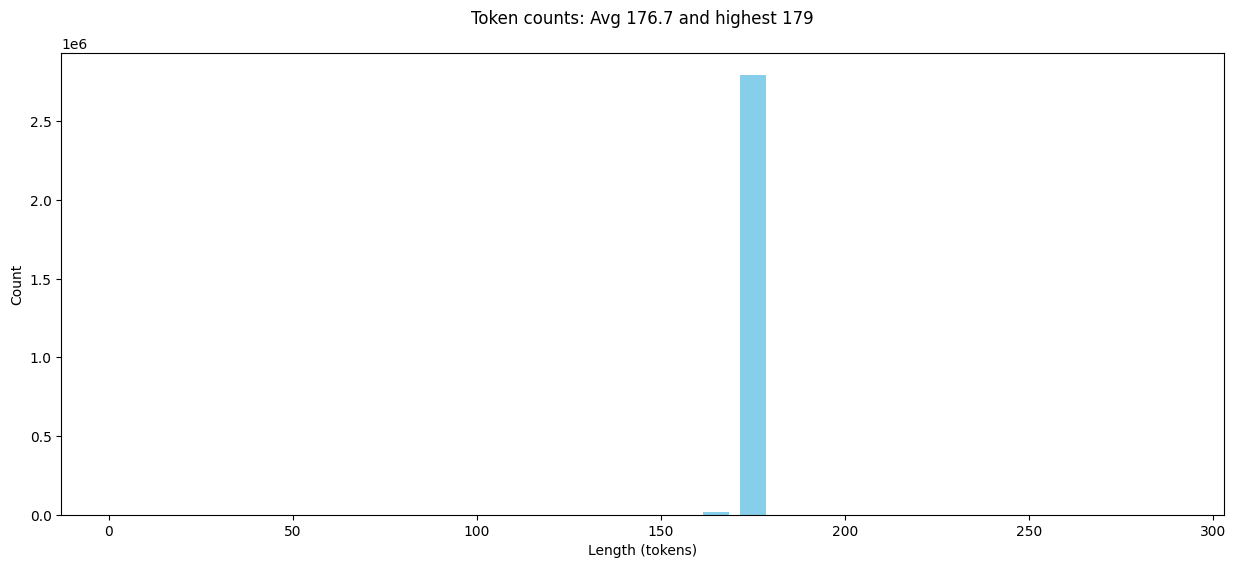

In [18]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

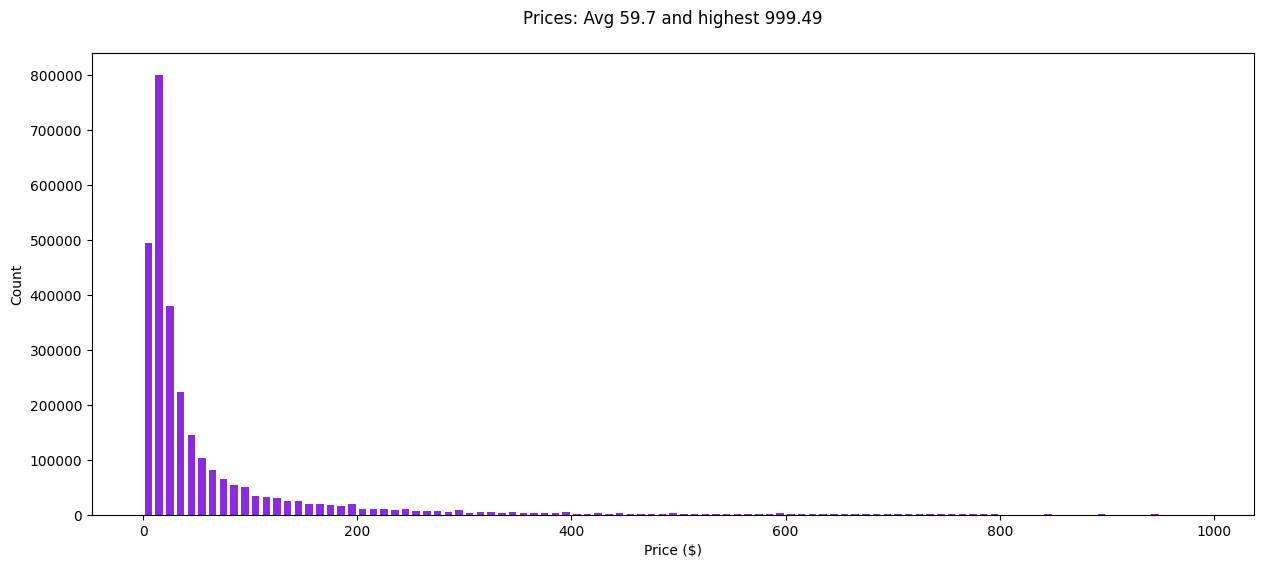

In [19]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

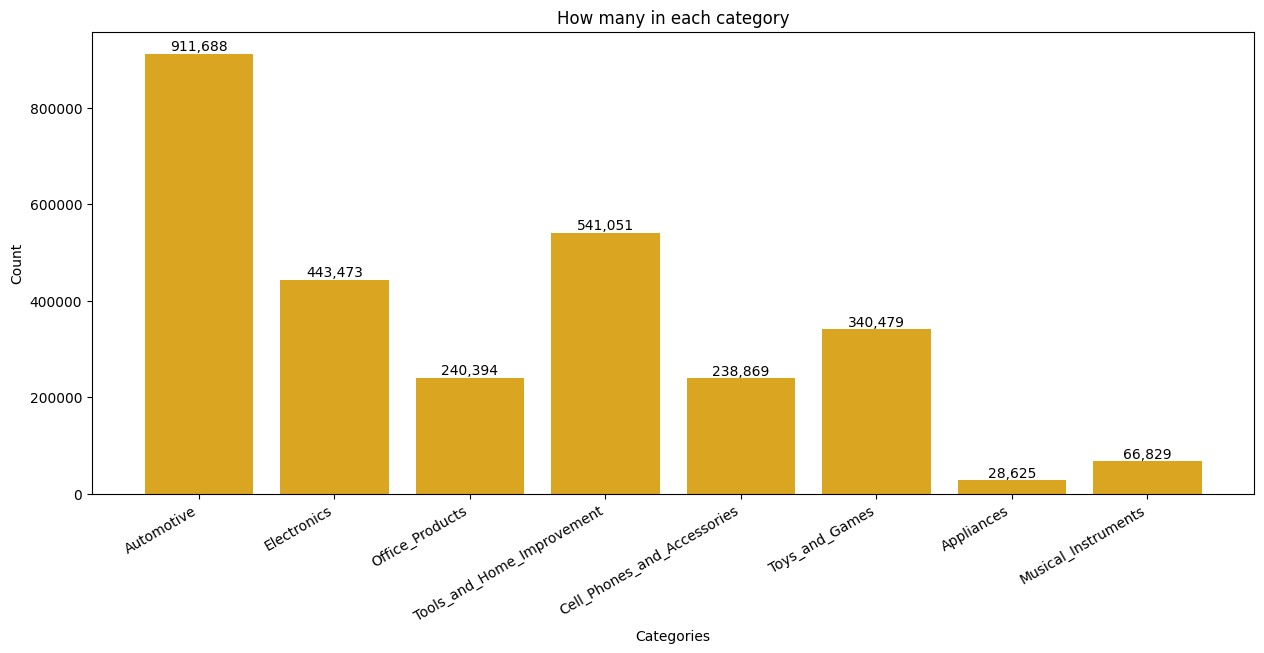

In [20]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [21]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [22]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Musical_Instruments' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 408,635 items in the sample


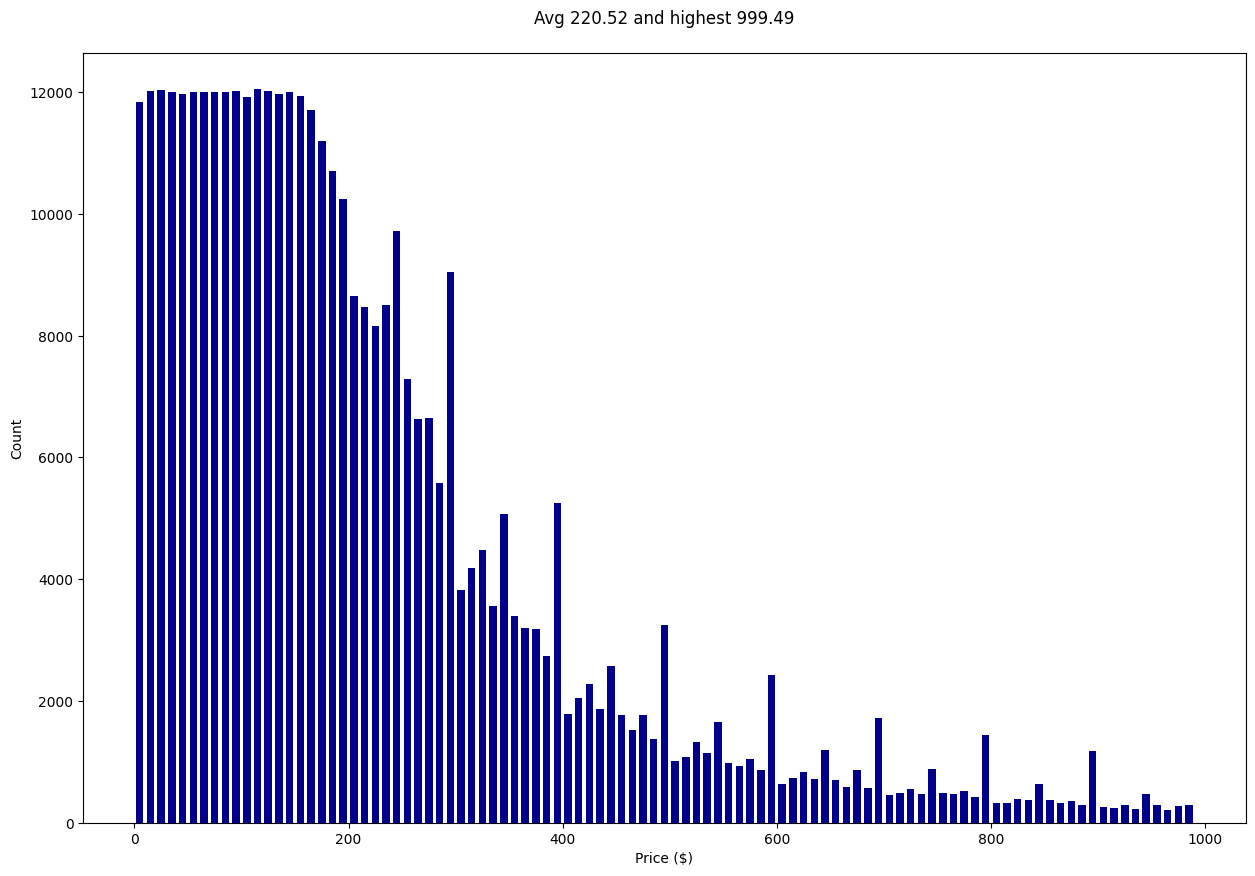

In [23]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

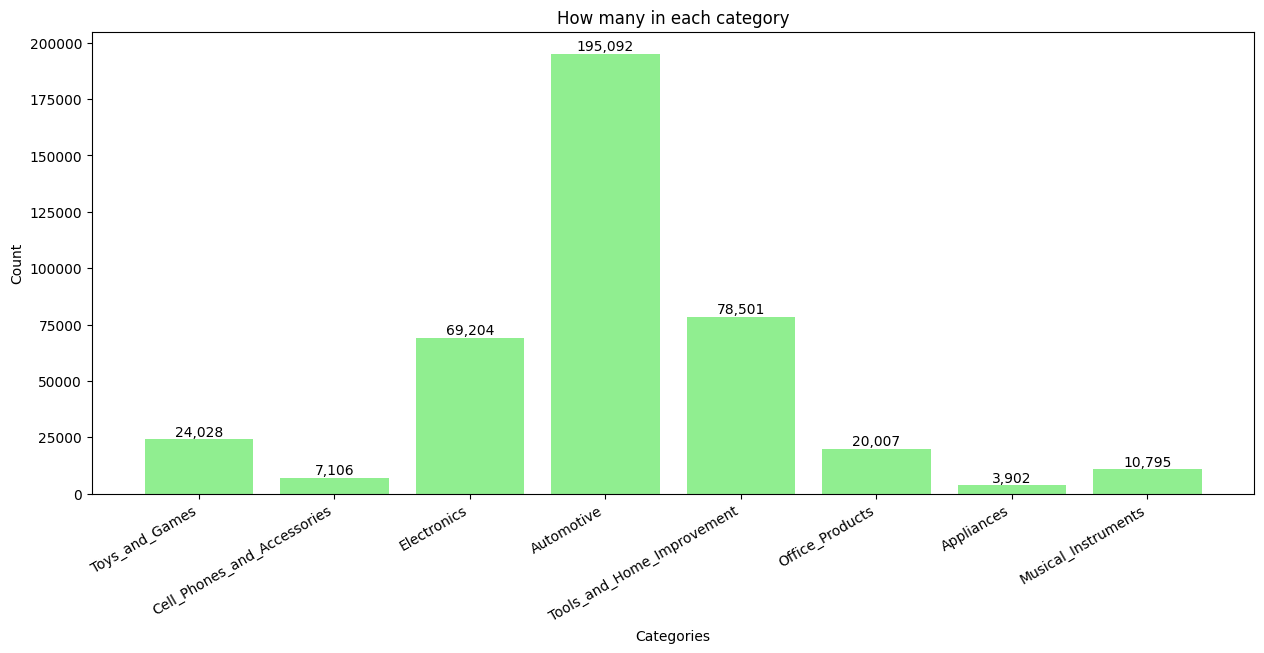

In [24]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

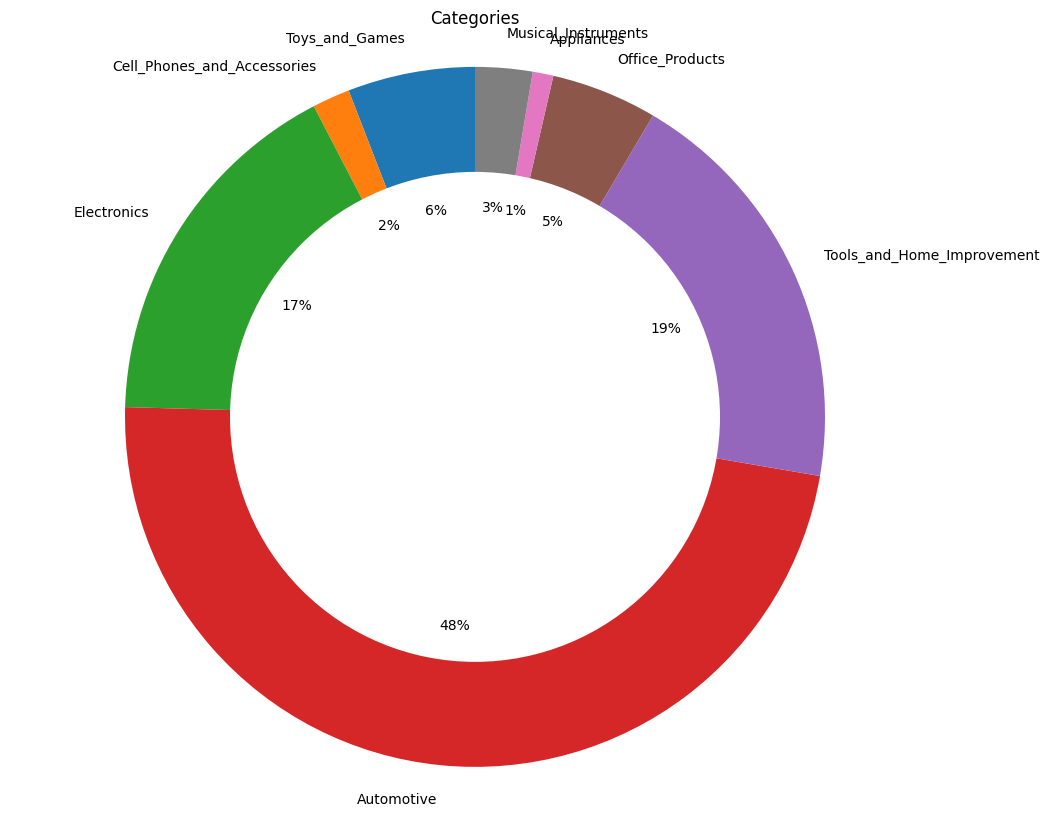

In [25]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated!

We've crafted an excellent dataset.

Let's do some final checks

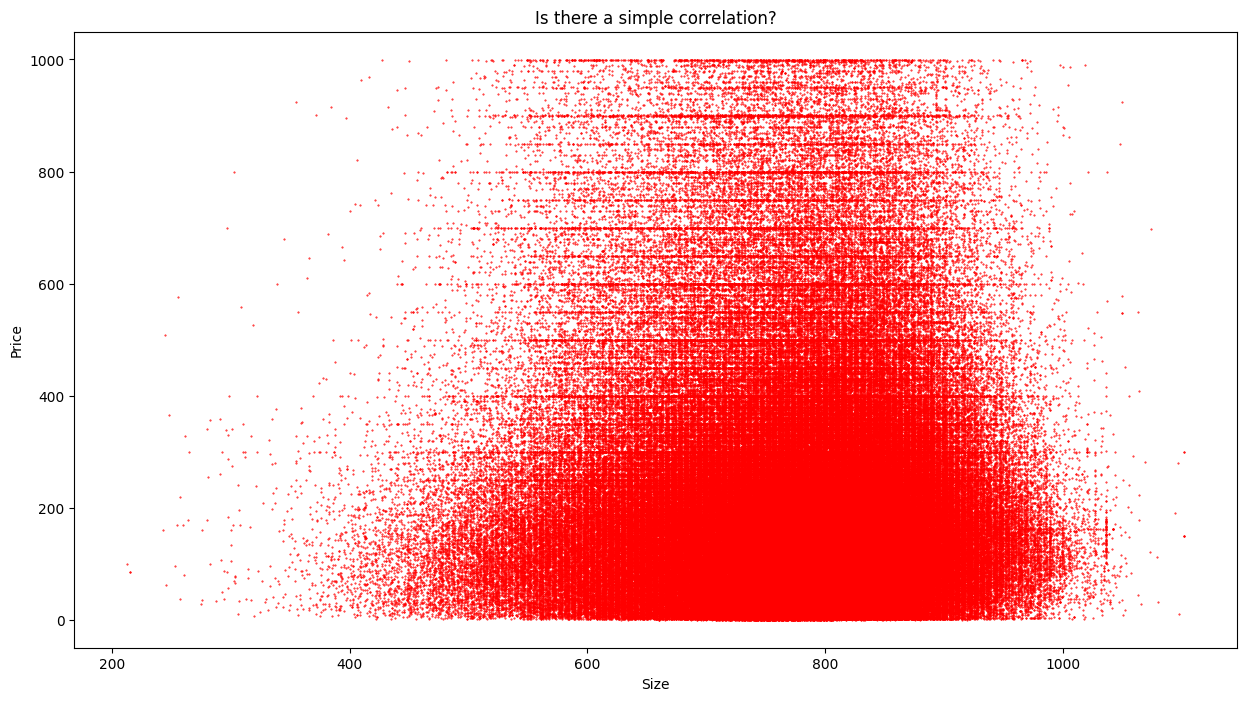

In [26]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [27]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [29]:
report(sample[7000])

How much does this cost to the nearest dollar?

* Car Magnet * Donald Trump Deal with It TRM 121
3.5” x 7.25” Magnets are sure to bring a smile. Magnets are digitally printed using high quality weatherproof vinyl and UV resistant inks. These Magnets are suitable for indoor or outdoor use. Great for cars, trucks, tool boxes, desks, refrigerators, anything metal. 100% satisfaction guaranteed. If you have a problem let us know and we will make it right or refund you money. 3.5” x 7.25” Magnet Heavy.030 vinyl clad magnets Printed with UV resistant Inks Waterproof Great for Cars and Trucks Will last for years Manufacturer StickerPirate, Available January 15, 2016

Price is $6.00
[220, 679, 21, 271, 7117, 374, 400, 21, 13, 410]
[' ', '201', '6', '\n\n', 'Price', ' is', ' $', '6', '.', '00']


## Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

# Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [30]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [31]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [ ]:
print(test[0].test_prompt())

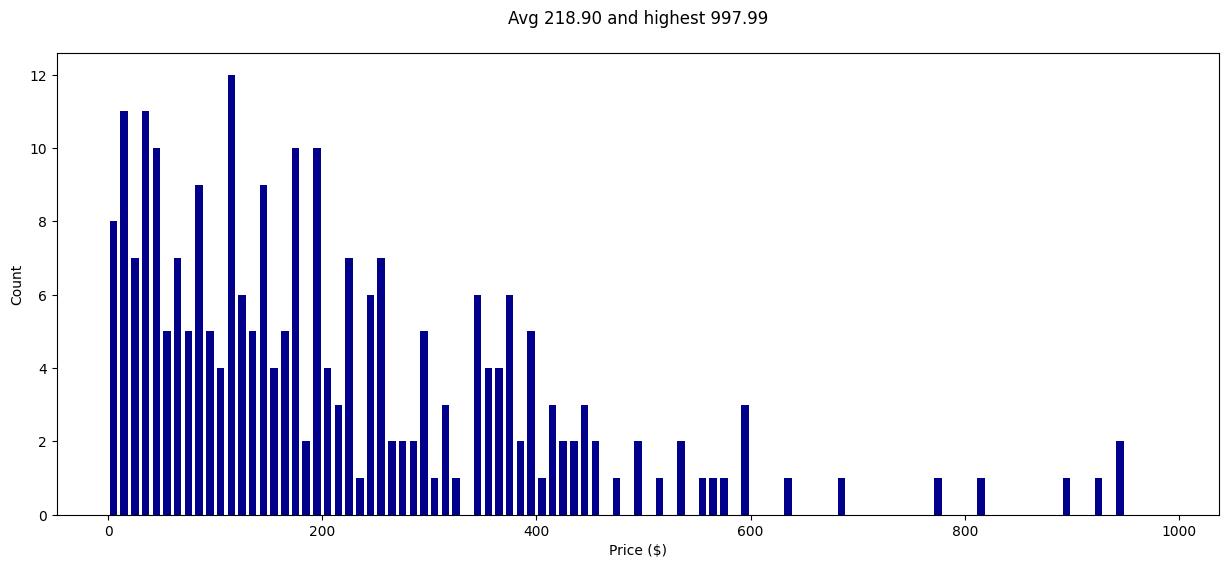

In [32]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [33]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [34]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

Why this happened: You have TWO tokens in your .env file:

HF_TOKEN = Read-only token ✅ for downloading
HF_WRITE_TOKEN = Write token ✅ for uploading

The diagnostic script was smart and automatically used HF_WRITE_TOKEN, which is why it succeeded. But your code was using HF_TOKEN (read-only), which is why it failed.
Try it now with HF_WRITE_TOKEN and it should work! 🚀

In [57]:
# The issue is that your token isn't being passed to push_to_hub(). Even though it's 
# in your .env file, you need to explicitly pass it.

import os
from dotenv import load_dotenv
from huggingface_hub import HfApi, whoami

# Load environment variables
load_dotenv()

print("=" * 60)
print("🔍 DIAGNOSING HUGGINGFACE TOKEN ISSUE")
print("=" * 60)

# Check all HF tokens in .env
token = os.getenv('HF_TOKEN')
write_token = os.getenv('HF_WRITE_TOKEN')  # Check if you have a separate write token

print("\n1️⃣ Checking tokens in .env file:")
if token:
    print(f"   ✅ HF_TOKEN found: {token[:10]}...{token[-10:]}")
else:
    print(f"   ❌ HF_TOKEN not found")

if write_token:
    print(f"   ✅ HF_WRITE_TOKEN found: {write_token[:10]}...{write_token[-10:]}")
else:
    print(f"   ℹ️  HF_WRITE_TOKEN not found (this is okay)")

# Determine which token to use
active_token = write_token if write_token else token

if not active_token:
    print("\n❌ ERROR: No token found in .env file!")
    print("   Add to your .env file: HF_TOKEN=hf_xxxxx")
    exit(1)

# Check token permissions
print(f"\n2️⃣ Checking token permissions:")
try:
    api = HfApi(token=active_token)
    user_info = whoami(token=active_token)
    
    username = user_info['name']
    print(f"   ✅ Username: {username}")
    
    # Check token scopes
    if 'auth' in user_info:
        scopes = user_info['auth'].get('accessToken', {}).get('role', 'unknown')
        print(f"   ✅ Token role: {scopes}")
    
    # Try to list user's datasets to verify write access
    try:
        # This is a safe operation that tests permissions
        datasets = api.list_datasets(author=username, limit=1)
        print(f"   ✅ Can read your datasets")
    except Exception as e:
        print(f"   ⚠️  Cannot read datasets: {e}")
    
except Exception as e:
    print(f"   ❌ Token validation failed: {e}")
    exit(1)

# Test if we can create/update a repo
print(f"\n3️⃣ Testing write permissions:")
test_repo = f"{username}/test-permissions-check"

try:
    # Try to create or access a test repo (this will show if write works)
    result = api.create_repo(
        repo_id=test_repo,
        token=active_token,
        repo_type="dataset",
        private=True,
        exist_ok=True  # Won't fail if it exists
    )
    print(f"   ✅ Write permissions confirmed!")
    print(f"   ✅ Successfully accessed: {result}")
    
    # Clean up - delete the test repo
    try:
        api.delete_repo(repo_id=test_repo, token=active_token, repo_type="dataset")
        print(f"   ✅ Cleaned up test repo")
    except:
        pass
    
except Exception as e:
    print(f"   ❌ WRITE PERMISSION FAILED: {e}")
    print(f"\n   🔧 FIX:")
    print(f"   1. Go to: https://huggingface.co/settings/tokens")
    print(f"   2. Delete your current token")
    print(f"   3. Create a NEW token with 'Write' permission checked")
    print(f"   4. Copy the new token (starts with hf_)")
    print(f"   5. Update your .env file: HF_TOKEN=hf_xxxxx")
    exit(1)

# Provide the working code
print("\n" + "=" * 60)
print("✅ YOUR TOKEN WORKS! USE THIS CODE:")
print("=" * 60)
print(f"""
import os
from dotenv import load_dotenv

load_dotenv()
token = os.getenv('HF_TOKEN')  # or 'HF_WRITE_TOKEN' if you have both

HF_USER = "{username}"
DATASET_NAME = f"{{HF_USER}}/pricer-data"

# ✅ IMPORTANT: Pass the token explicitly!
dataset.push_to_hub(
    DATASET_NAME, 
    private=True, 
    token=token  # <-- This is REQUIRED
)
""")

print("\n⚠️  KEY POINT: You MUST pass token=token to push_to_hub()!")
print("   Without it, the upload will fail with 403 Forbidden.")

🔍 DIAGNOSING HUGGINGFACE TOKEN ISSUE

1️⃣ Checking tokens in .env file:
   ✅ HF_TOKEN found: hf_FJKQhRv...fTvDbhrAwK
   ✅ HF_WRITE_TOKEN found: hf_RwEAlmf...PTDheHifRV

2️⃣ Checking token permissions:
   ✅ Username: MLShare
   ✅ Token role: write
   ✅ Can read your datasets

3️⃣ Testing write permissions:
   ✅ Write permissions confirmed!
   ✅ Successfully accessed: https://huggingface.co/datasets/MLShare/test-permissions-check
   ✅ Cleaned up test repo

✅ YOUR TOKEN WORKS! USE THIS CODE:

import os
from dotenv import load_dotenv

load_dotenv()
token = os.getenv('HF_TOKEN')  # or 'HF_WRITE_TOKEN' if you have both

HF_USER = "MLShare"
DATASET_NAME = f"{HF_USER}/pricer-data"

# ✅ IMPORTANT: Pass the token explicitly!
dataset.push_to_hub(
    DATASET_NAME, 
    private=True, 
    token=token  # <-- This is REQUIRED
)


⚠️  KEY POINT: You MUST pass token=token to push_to_hub()!
   Without it, the upload will fail with 403 Forbidden.


In [58]:
import os
from dotenv import load_dotenv

load_dotenv()
token = os.getenv('HF_WRITE_TOKEN')  # ✅ This is your WRITE token

HF_USER = "MLShare"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True, token=token)  # ✅ Must pass token!

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/MLShare/pricer-data/commit/2ad030832eef9829acc23ac5f52542aa520db59e', commit_message='Upload dataset', commit_description='', oid='2ad030832eef9829acc23ac5f52542aa520db59e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MLShare/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MLShare/pricer-data'), pr_revision=None, pr_num=None)

In [59]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

## Todos for you:

- Investigate the dataset more!
- Confirm that the tokenizer tokenizes all 3 digit prices into 1 token